# Stroke pathway timing distributions

## Aim

Visualises distribution of timings for:
* (Known) Onset to arrival time
* Arrival to scan time
* Scan to needle time

Finds the best distributions to fit the above.

Replicates SAMueL-1 analyses [available here](https://samuel-book.github.io/samuel-1/descriptive_stats/06_distributions.html)


## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy.stats

# Hide warnings (to hide runtime error)
import warnings
warnings.filterwarnings("ignore")

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Plot distributions

In [4]:
def plot_dist(times, binwidth, ax, title, details):
    '''
    Plots distribution of the provided series
    times = series
    binwidth = integer, width of bins for histogram
    ax = axes object to plot histogram on
    title = string, title for plot and xlabel
    details = string, extra details to add for xlabel
    '''
    ax.hist(times,
            bins=np.arange(min(times),
                           max(times) + binwidth,
                           binwidth),
            rwidth=1)
    ax.set_title(title)
    ax.set_xlabel(title + ' ' + details)
    ax.set_ylabel('Number of patients')

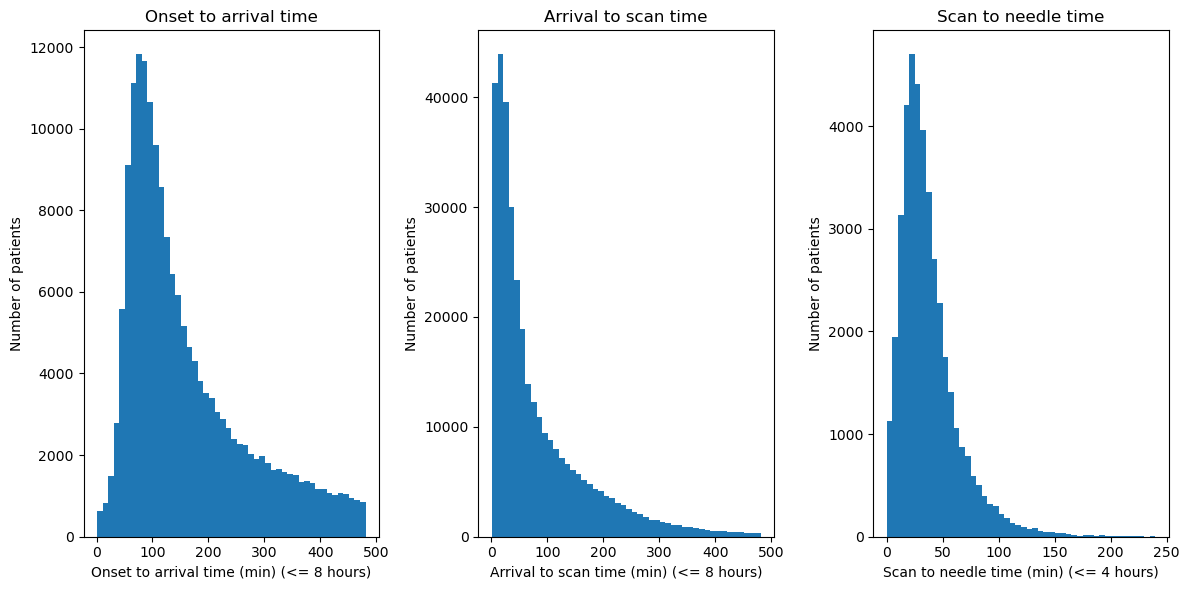

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Onset to arrival time (within 8 hours)
plot_dist(times=data_full.loc[data_full['onset_to_arrival_time'] <= 480,
                              'onset_to_arrival_time'],
          binwidth=10,
          ax=ax[0],
          title='Onset to arrival time',
          details='(min) (<= 8 hours)')

# Arrival to scan time (within 8 hours)
plot_dist(times=data_full.loc[data_full['arrival_to_scan_time'] <= 480,
                              'arrival_to_scan_time'],
          binwidth=10,
          ax=ax[1],
          title='Arrival to scan time',
          details='(min) (<= 8 hours)')

# Scan to needle time (within 4 hours)
plot_dist(times=data_full.loc[data_full['scan_to_thrombolysis_time'] <= 240,
                              'scan_to_thrombolysis_time'],
          binwidth=5,
          ax=ax[2],
          title='Scan to needle time',
          details='(min) (<= 4 hours)')

plt.tight_layout()
plt.show()

## Fit distributions

Fit distributions to bootstrapped sample of 10,000 patients

In [6]:
def fit_distribution(data_to_fit, samples=10000):
    '''
    Investigate fit of ten different distributions
    Parameters:
    data_to_fit - Series with data to fit
    samples - Number of times to sample with replacement (default 10000)
    Returns:
    y_std - Array with 10,000 items, which are the bootstrapped times
    '''
    # Convert to array and remove invalid values
    # (which shouldn't exist - but just in case!)
    yy = data_to_fit[(data_to_fit > 0) & (data_to_fit < np.inf)].values

    # Bootstrap sample - generate random sample of 10,000
    # patients from array. Replace=True, meaning the same
    # value of yy can be sampled multiple times, as a
    # bootstrap sample is when you draw randomly with replacement
    yy = np.random.choice(a=yy, size=samples, replace=True)

    # Reshape from 1D array (10000,) to 2D array with 10,000 rows (10000, 1),
    # so can then standardise the data (mean 0, SD 1)
    yy = yy.reshape(-1, 1)
    y_std = StandardScaler().fit_transform(yy)

    # Add +/- 0.0001 Std Dev jitter to avoid failure of fit for discrete data
    # Sample between -0.0001 and 0.0001, and add those values to yy
    jitter = np.random.uniform(low=-0.0001, high=0.0001, size=samples)
    y_std += jitter.reshape(-1, 1)

    # Test 10 distributions
    dist_names = ['beta', 'expon', 'gamma', 'lognorm', 'norm',
                  'pearson3', 'triang', 'uniform',
                  'weibull_min', 'weibull_max']

    # Create empty lists to store results
    chi_square = []
    p_values = []

    # Set up 50 bins for chi-squared test. Observed data will be approximately
    # normally distributed across all bins
    # Linspace returns evently spaced numbers over specified interval
    # i.e. [0, 2, 4, 6...]
    bins = np.linspace(start=0, stop=100, num=51)
    # Calculate the qth percentile of the data (i.e. 0th, 2nd, 4th, 6th, ...)
    cutoffs = np.percentile(y_std, bins)
    # Find observed frequency in each bin (should be 200), then use that to
    # create array with cumulative frequency
    observed_freq = np.histogram(y_std, bins=cutoffs)[0]
    cum_observed_freq = np.cumsum(observed_freq)

    # Convert values into 1D array
    y_std = y_std.flatten()

    # Loop through the candidate distributions
    for distribution in dist_names:
        # Use string to get relevant distribution object and fit it,
        # returning fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        # Perform Kolmogorov-Smirnov test for goodness of fit and
        # extract p-value. Round to 5 d.p. and save to list
        p = scipy.stats.kstest(y_std, distribution, args=param).pvalue
        p_values.append(np.round(p, 5))

        # Get expected counts in percentile bins for that distribution
        # Further details:
        # Find expected counts using the CDF (cumulative distribution function)
        # CDF describes probably distribution of random variable.
        # It calculates the probability
        # of an observation equal or less than a value.
        # Param has the maximum likelihood estimates of the shape parameters,
        # location, and (if applicable) scale of the distribution. The
        # starred expression is to treat each as seperate positional arguments
        cdf_fitted = dist.cdf(cutoffs, *param[:-2],
                              loc=param[-2], scale=param[-1])
        expected_freq = []
        for bin in range(len(bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_freq.append(expected_cdf_area)

        # Calculate chi-squared
        # Find expected counts for each bin by multiplying by number of samples
        # Create array with those as cumulative counts
        expected_freq = np.array(expected_freq) * samples
        cum_expected_freq = np.cumsum(expected_freq)
        ss = sum(((cum_expected_freq - cum_observed_freq) ** 2) /
                 cum_observed_freq)
        chi_square.append(ss)

    # Collate results and sort by goodness of fit
    results = pd.DataFrame({
        'distribution': dist_names,
        'chi_square': chi_square,
        'p_value': p_values})
    results.sort_values(['chi_square'], inplace=True)

    display(f'Distributions sorted by goodness of fit:')
    display(results)

    # Get name of the best distribution
    best = results.reset_index().distribution[0]

    return best, y_std

In [7]:
def plot_chosen_distribution(best, y_std):
    '''
    Creates plots for chosen distribution - histogram of standardised
    values with the chosen distribution overlaid, and a P-P plot
    Inputs:
    best - string, best distribution from fit_distribution()
    y_std - array, contains bootstrapped times from fit_distribution()
    '''
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Create histogram of standardised values
    h = ax[0].hist(y_std, bins=100, color='grey', alpha=0.5)
    ax[0].set_xlabel('Standardised value')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title('Histogram of standardised bootstrapped values')

    # Add line for distribution that fit best
    # Get X values from histogram
    x = h[1]
    # Set up distribution and store distribution parameters
    dist = getattr(scipy.stats, best)
    param = dist.fit(y_std)
    # Get line for distribution
    # Param has the maximum likelihood estimates of the shape parameters,
    # location, and (if applicable) scale of the distribution. The
    # starred expression is to treat each as seperate positional arguments
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    # Trapz is used to scale to match the observed data
    scale_pdf = np.trapz(h[0], h[1][:-1]) / np.trapz(pdf_fitted, x)
    pdf_fitted *= scale_pdf
    # Add line to the plot
    ax[0].plot(x, pdf_fitted, label=best, alpha=1)
    ax[0].legend()

    # Plot observed and theoretical cumulative distribution (P-P plot)
    # Get size
    size = len(y_std)
    # Get 10,000 random numbers from distribution
    norm = dist.rvs(*param[0:-2], loc=param[-2], scale=param[-1], size=size)
    norm.sort()
    # Calculate cumulative distributions
    bins = np.percentile(norm, range(0, 101))
    y_std_counts, bins = np.histogram(y_std, bins)
    norm_counts, bins = np.histogram(norm, bins)
    cum_y_std = np.cumsum(y_std_counts)
    cum_norm = np.cumsum(norm_counts)
    cum_y_std = cum_y_std / max(cum_y_std)
    cum_norm = cum_norm / max(cum_norm)
    # Plot observed and theoretical distributions
    ax[1].plot(cum_norm, cum_y_std, 'o', label=best, alpha=0.5)
    ax[1].set_title('P-P plot')
    ax[1].set_xlabel('Theoretical cumulative distribution')
    ax[1].set_ylabel('Observed cumulative distribution')
    ax[1].legend()
    # Add diagonal line
    ax[1].plot([0, 1], [0, 1], 'r--')

    # Display plot
    plt.tight_layout(pad=2)
    plt.show()

'Distributions sorted by goodness of fit:'

,distribution,chi_square,p_value
3,lognorm,802.724032,0.0
2,gamma,2346.218327,0.0
5,pearson3,2346.328601,0.0
9,weibull_max,3763.649893,0.0
8,weibull_min,4762.978273,0.0
6,triang,7611.830586,0.0
4,norm,17454.803563,0.0
7,uniform,34665.888954,0.0
1,expon,53728.310272,0.0
0,beta,63197.954477,0.0


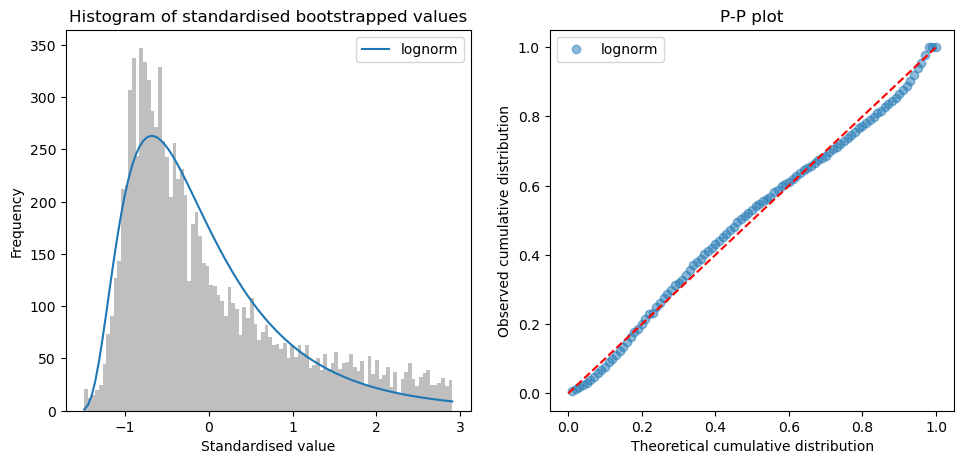

In [8]:
# Onset to arrival time (restrict to 8 hours)
data_to_fit = data_full.loc[
    data_full['onset_to_arrival_time'] <= 480,
    'onset_to_arrival_time']

# Check fit of distributions
best, y_std = fit_distribution(data_to_fit)

# Plot best fitting distribution
plot_chosen_distribution(best, y_std)

'Distributions sorted by goodness of fit:'

,distribution,chi_square,p_value
3,lognorm,995.391500,0.0
1,expon,2412.158067,0.0
2,gamma,4135.011558,0.0
5,pearson3,4194.198740,0.0
0,beta,6729.380875,0.0
8,weibull_min,8256.838004,0.0
9,weibull_max,27665.051536,0.0
6,triang,59039.646003,0.0
4,norm,62197.760046,0.0
7,uniform,114863.744150,0.0


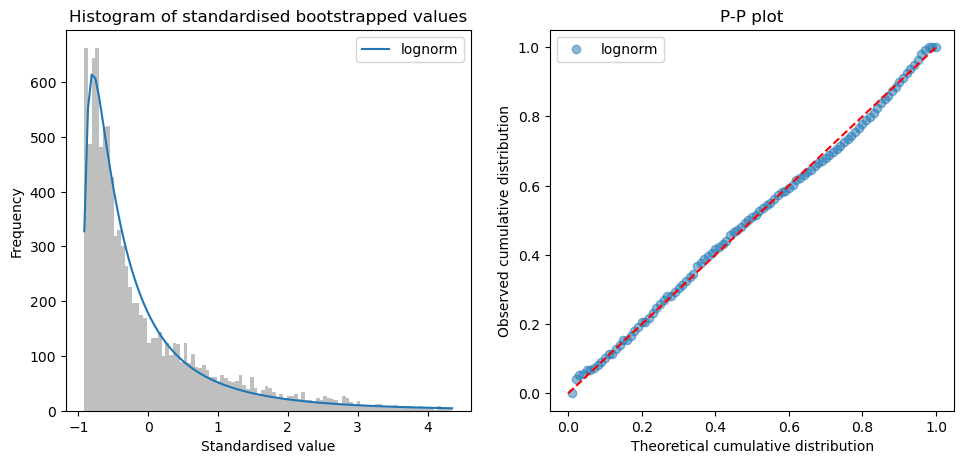

In [9]:
# Arrival to scan time (restrict to 8 hours)
data_to_fit = data_full.loc[
    data_full['arrival_to_scan_time'] <= 480,
    'arrival_to_scan_time']

# Check fit of distributions
best, y_std = fit_distribution(data_to_fit)

# Plot best fitting distribution
plot_chosen_distribution(best, y_std)

'Distributions sorted by goodness of fit:'

,distribution,chi_square,p_value
3,lognorm,96.117945,0.00027
5,pearson3,330.124322,0.00000
2,gamma,330.284266,0.00000
0,beta,450.608940,0.00000
8,weibull_min,1373.262433,0.00000
4,norm,16512.021391,0.00000
1,expon,29281.649124,0.00000
6,triang,61994.391204,0.00000
7,uniform,123216.202393,0.00000
9,weibull_max,227120.802863,0.00000


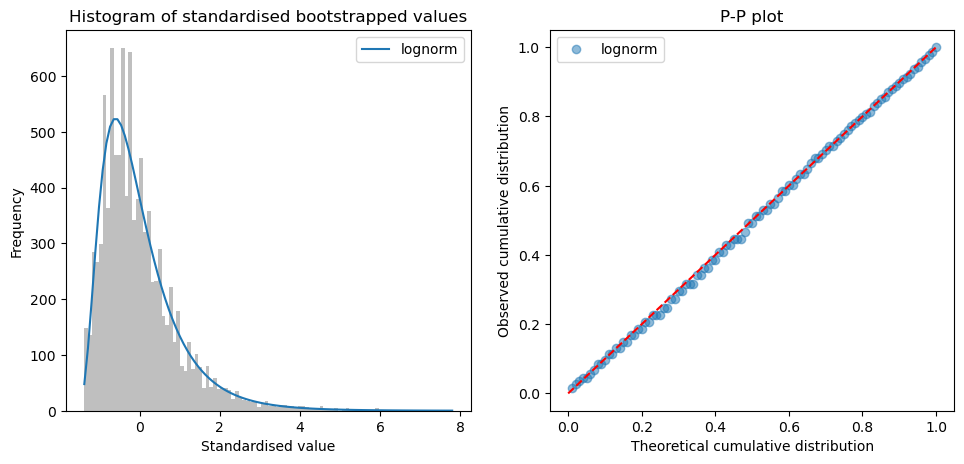

In [10]:
# Scan to needle time (restrict to 4 hours)
data_to_fit = data_full.loc[
    data_full['scan_to_thrombolysis_time'] <= 240,
    'scan_to_thrombolysis_time']

# Check fit of distributions
best, y_std = fit_distribution(data_to_fit)

# Plot best fitting distribution
plot_chosen_distribution(best, y_std)

## Observations

* All timings have a right skew, with lognormal having minimum chi-squared
* No distribution was a perfect fit for the data (all had p<0.01)
* Choose log normal distributions for pathway process times